In [1]:
%load_ext autoreload
%autoreload 2
from utils.data import load_data, get_word_tokenized_corpus, get_data_property, get_data_chunks
from utils.embeddings import train_fasttext_embedding, get_chunk_embeddings, save_fasttext, load_fasttext
from utils.features import get_features
from main import setup_chunk_embeddings, setup

In [2]:
%reload_ext autoreload

In [3]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [4]:
import glob
import numpy as np
import pandas as pd
from os.path import exists
from sklearn.linear_model import Lasso

In [5]:
# SET THIS FLAG IF IMPORTING EMBS FROM MATLAB
from_MATLAB = True
# SET THIS FLAG FOR THE MODE (train, load, or test)
mode = 'test'

if mode == 'train':
    # Train Model
    class Args:
    #     model_name = 'fasttext_model/ft_model.model'
        model_name = 'fasttext_model/cc.en.300.bin'
        data_file = 'data/dblp-ref-0.json'
        chunk_embs_file = 'none'
        proj_dir = './saved/'
        limit = 30000
        T = 20
        train_model = True

    args=Args()

    ft_model, abstracts, citation_counts = setup(args)
    chunk_embs = setup_chunk_embeddings(args, ft_model, abstracts)
elif mode == 'load':
    # Load Chunks
    class Args:
        model_name = 'fasttext_model/cc.en.300.bin'
        data_file = 'data/dblp-ref-0.json'
        chunk_embs_file = 'data/chunk_embs.txt'
        proj_dir = './saved/'
        limit = 30000
        T = 20
        train_model = False

    args=Args()
elif mode == 'test':
    # Test sentences
    # Load Chunks
    class Args:
        model_name = 'fasttext_model/wiki-news-300d-1M.vec'
        proj_dir = './saved/'
        T = 20
        train_model = False

    args=Args()
    ft_model = load_fasttext(args.proj_dir + args.model_name)

if from_MATLAB and mode != 'test':
    df = pd.read_table('./saved/data/toubia_embs.txt', dtype=float, header=None, sep=',').fillna(0).values
    chunk_embs = [np.trim_zeros(df[i], 'b').reshape(300,-1).transpose() for i in range(len(df))]
elif mode != 'test':
    chunk_embs = setup_chunk_embeddings(args, None, None)


speed
2.049154251312333
2.1673683490803004
2.127699996346572
2.2576259124213656

volume
1.2746961058617894
1.332545200618519
1.3301977342317437
1.3600596847755393

circuitousness
0.048155088874430235
0.06889704270059227
0.07068307047225517
0.1107059197908666

distances


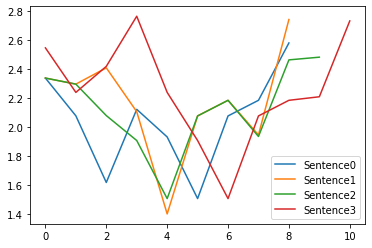

In [18]:
import matplotlib.pyplot as plt

if mode == 'test':
    sentences = ['The food here is ok but not worth the price.', \
                 'The food is mediocre and not worth the ridiculous price.', \
                 'The food is good but not worth the horrible customer service.', \
                 'The pizza and burgers are good but not worth the wait times.']

    chunks = [get_data_chunks(sent, T=args.T) for sent in sentences]
    chunk_embs = np.array([get_chunk_embeddings(ft_model, chunk) for chunk in chunks])
    features = [get_features(chunk_emb) for chunk_emb in chunk_embs]
    
    for key in features[0].keys():
        print('\n' + key)
        
        if key == 'distances':
            for i, feature in enumerate(features):
                plt.plot(range(len(feature['distances'])), feature['distances'], label=f'Sentence{i}')
            plt.legend()

        else:
            for feature in features:
                print(feature[key])
            
    

In [ ]:
features = [get_features(chunk_emb, feature_list=['speed2']) for chunk_emb in chunk_embs]